[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Eldave93/machine-learning-workbooks/blob/main/07-classical-classification/07_workbook.ipynb)

# Workbook 07 - "Classical" Classification
by [Dr. David Elliott](https://eldave93.netlify.app/)

1. [Workspace Setup](#setup)

2. [Problem Understanding](#problem)

3. [Data Preparation](#prep)

4. [Exploratory Data Analysis](#eda)

5. [Data Pre-Processing](#pre)

6. [Model Exploration](#explore)

7. [Model Refinement](#refine)

8. [Summary](#sum)

9. [Extra](#extra)

__TODO__
- Move the KNN explanation into a previous notebook, you could keep the KNN questions though.
- Add SVM explanation and questions

The aim of this workbook is to start to examine what models we can use to predict categorical variables (e.g. Yes & No).

# 1. Workspace Setup
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.1. Google Colab
If you are using google colab then you can follow the below instructions to get setup.

First lets check if you are actually using google colab.

In [1]:
try:
    import google.colab
    COLAB=True
    
    # set the week code
    WORKSHOP_NAME = "07-classical-classification"
except:
    COLAB=False

If using colab you will need to install the dependencies and upload the files associated with this workshop to the temporary file store.

To do this:
1. Download the workbook repository as a .zip file from GitHub (Green "Code" button, "Download ZIP"),
2. On Google Colab click the folder icon on the left panel
3. Click the page icon with the upwards arrow on it
4. From your local computers file store, upload the .zip file (e.g. `machine-learning-workbooks-main.zip`)

__Note__ 

- Make sure to restart the runtime after installing to ensure everything works correctly.

In [2]:
if COLAB:
    import os

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists("machine-learning-workbooks-main") and os.path.exists("machine-learning-workbooks-main.zip"):
          !unzip machine-learning-workbooks-main.zip
          
    print("Setting working directory to:")
    %cd ./machine-learning-workbooks-main/{WORKSHOP_NAME}

else:
    print("Colab is not being used")

Colab is not being used


As seen above, I automatically set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. 

## 1.2. Local Workspace

If your using a local workspace you will need all the packages to run this notebook.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import imblearn
import sys

sys.path.append('./scripts') # add scripts to the path for use later

If you do not already have them the script below, provided `AUTO_INSTALL = True`, will install them for you.

In [4]:
AUTO_INSTALL = False

if AUTO_INSTALL:
    !{sys.executable} -m pip install -r ./scripts/requirements.txt

## 1.3. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workshop folder (e.g. `01-end_to_end`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).

In [5]:
%run scripts/create_widgets.py 07

<IPython.core.display.Javascript object>

Buttons created!


In [6]:
# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

---

# 2. Problem Understanding <a id='problem'></a>

The data for this week's workshop comes from the Introduction to Statistical Learning textbook. The data for this one is admittedly simulated, but it is useful for demonstrating classification methods.

These data are available in `Default.csv` which is provided with this worksheet. 

__Default:__ Customer default records for a credit card company

_"We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance."_$^5$

This data is also a good example of an imballanced problem. Class imbalance is a quite common problem when working with real-world data. This occours when examples from one class or multiple classes are over-represented in a dataset (e.g. spam filtering, fraud 
detection, disease screening).

In [7]:
df = pd.read_csv("Data/Default.csv", index_col=0)

# for now lets just drop the student varible.
df = df.drop("student", axis=1)
df.head()

default      balance       income
1      No   729.526495  44361.62507
2      No   817.180407  12106.13470
3      No  1073.549164  31767.13895
4      No   529.250605  35704.49394
5      No   785.655883  38463.49588

Using the data above (which we will imagine comes from a credit card company), we are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance.$^5$

In [8]:
output = "default"

This is going to be a "supervised learning" problem, were we learn from the data we have available to us (already labeled for deafults) so in the future we can test new customers to predict if they will default on the loan. For example...

In [9]:
# set the random seed so the same example is selected each time
np.random.seed(45)

# select a random wine example
example = df.sample()

# remove our output attribute
X_example = example.drop(output, axis=1)

X_example

balance       income
4133  933.104366  24113.91729

In [10]:
from helper_functions import create_example_model

# Don't worry about understanding this line of code - you will learn how to create your
# own `log_pipe` without using `create_example_model` as this is just an example so you
# don't need to see the code that went into making this model yet.
example_log_pipe = create_example_model(df.drop(example.index[0]), output)

# make a prediction with our model
example_log_pipe.predict(X_example)

array(['No'], dtype=object)

Lets check if the owner of this account did default?

In [11]:
example.loc[:,output]

4133    No
Name: default, dtype: object

Good! It was able to predict what the person did not default without ever seeing this specific balance and income combination before.

Lets have a look at how we can make our own model to do this (essentially what I did inside the function create_example_model)!

---

# 3. Data Preparation  <a id='prep'></a>

Lets start by seeing if we need to do any data cleaning before exploring it further.

---

### 🚩 Exercise 1

Examine the structure of the data.
- How many observations are in the dataset?
- What are the data types?

In [12]:
%run scripts/show_solutions.py 07_ex1

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 2

Do you observe anything of note from descriptive statistics that may influence our models?

In [13]:
%run scripts/show_solutions.py 07_ex2

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 3

Are there any missing values?

In [14]:
%run scripts/show_solutions.py 07_ex3

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets now create our feature and output ("responce") objects.

In [15]:
data_x, data_y = df.drop(output, axis=1), df[output]

print(data_x.shape)
print(data_y.shape)

(10000, 2)
(10000,)


---

At this point we probably should split our training and test sets up (before we start exploring relationships too much!). When splitting our data up we need to account for the class distribution, particularly when it is imballanced. The reason for this is when data is highly imballanced we want our test and validation sets to reflect the distribution of the thing we are trying to predict.

In [16]:
print(color.BOLD+color.UNDERLINE+"Class Distribution (%)"+color.END)
# get our null accuracy rate 
data_y.value_counts(normalize=True)*100

Class Distribution (%)


No     96.67
Yes     3.33
Name: default, dtype: float64

As can be seen above, we have an imballance in our responce varible which we should try keep proportional in our test set. Therefore we can use `stratify = data_y` to ensure this remains the same in the training and test sets.

In [17]:
from sklearn.model_selection import train_test_split
features = list(data_x.columns)
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=42)

print(color.BOLD+color.UNDERLINE+"Training Distribution"+color.END)
display(pd.Series(y_train).value_counts(normalize=True)*100)
print(color.BOLD+color.UNDERLINE+"Test Distribution"+color.END)
display(pd.Series(y_test).value_counts(normalize=True)*100)

Training Distribution


No     96.666667
Yes     3.333333
dtype: float64

Test Distribution


No     96.7
Yes     3.3
dtype: float64

---

# 4. Exploratory Data Analysis <a id='eda'></a>

This is quite straight forward data having only two features, but its still worth having a look at how they relate to each other and the outcome variable first.

---

### 🚩 Exercise 4

Look at how the variables relate to each other.

In [18]:
%run scripts/show_solutions.py 07_ex4

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 5. Data Pre-Processing <a id='pre'></a>

Not really too much we need to do for this data because it is already pretty ready to go... 

We should could encode output variable to an integer (0,1) for our model to predict like so.

__Note__
- Some methods with scikit-learn can handle the conversation from strings for you but others can't so best to turn them to 0's and 1's.

In [19]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_val = LE.transform(y_val)
y_test = LE.transform(y_test)

Also some methods of implimenting Logistic regression do not "require" scaling of the features, however, due to the implimentation in Scikit-Learn scaling is very much reccomended! In this case as well our features are on quite different scales so it will be a good idea to do this...

__Note__
- Notice how on the validation and test sets I am only using `transform` - this is because you need to use the mean and standard deviation from the training set!

In [20]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train_ = SS.fit_transform(X_train)
X_val_ = SS.transform(X_val)
X_test_  = SS.transform(X_test)

...however as we will be using a `pipeline`, we don't need to worry about doing this yet.

# 6. Model Exploration <a id='explore'></a>

For this workbook we will be exploring and refining two different models, Logisitic Regression and K-Nearest-Neighbours. While we are learning about them, lets first reduce the data down to use for examples.

In [21]:
np.random.seed(42)

# for this example to work I need to ballance the data...more on this
# later.
df['freq'] = 1./df.groupby('default')['default'].transform('count')
example = df.sample(100, weights="freq")

## 6.1. Logistic Regression

Consider this scatter plot showing a sample of people and whether they default or not based on their credit balance. If we were to fit a regression model, what do you think the line might look like?

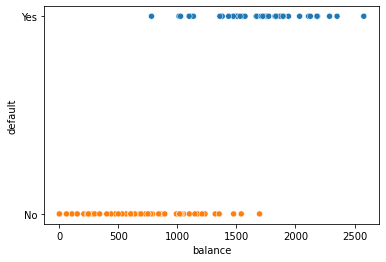

In [22]:
sns.scatterplot(data = example, y = "default", x ="balance", hue="default", legend=False)
plt.show()

It would look like the regression line below... not super useful as we only want to predict 1 ("Yes") or 0 ("No").

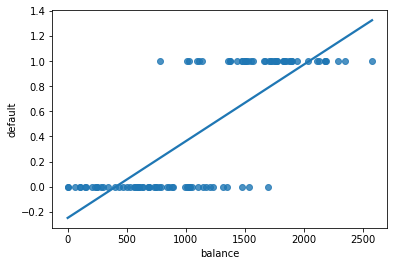

In [23]:
sns.regplot(y = (example["default"]=="Yes").astype(int), 
            x = example["balance"], ci=None)
plt.show()

This is where logistic regression comes in. Instead of trying to predict a value on a continuous scale, it will try and predict a label through the use of a logistic function. Logistic Regression can only predict binary values (0/1, yes/no, true/false, etc). There are methods we can use it to predict more labels which you may want to look into in the future. 

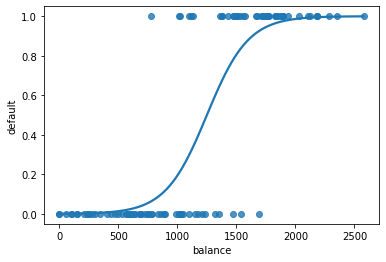

In [24]:
sns.regplot(y = (example["default"]=="Yes").astype(int), 
            x =example["balance"], logistic=True, ci=None)
plt.show()

In order to make a prediction the model assigns each observation a "probability" of being 0 or being 1. In otherwords, rather than just being 0 or 1 as above, the model outputs a probability between 0 and 1.

Typically we use 50% as the threshold where anything above 50% is assigned a 1 (blue) and below a 0 (orange).

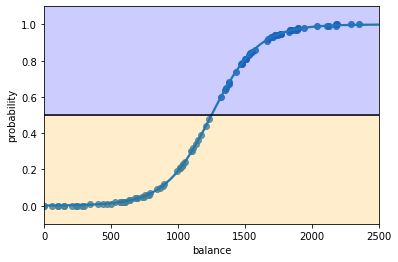

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(example["balance"].to_numpy().reshape(-1, 1), example["default"])

probs = pd.DataFrame(logreg.predict_proba(example["balance"].to_numpy().reshape(-1, 1)).round(2), 
                     columns = ["No", "Yes"])

fig, ax = plt.subplots()

sns.regplot(y = probs["Yes"], x =example["balance"], 
            logistic=True, ci=None, ax=ax)
plt.axline((0, 0.5), slope=0, c="black")

plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], -0.1, 0.5, color='orange', alpha=0.2)
plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], 0.5, 1.1, color='blue', alpha=0.2)
plt.xlim(0,2500)
plt.ylim(-0.1,1.1)
plt.ylabel("probability");

So if we want to look at what balance value we would use to predict a default in this case that would be around \\$1250. This means that for anyone with a balance under \\$1250 this model predicts they defaulted, and anyone higher did. 

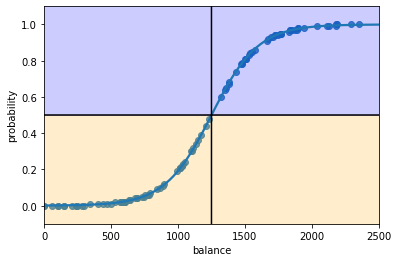

In [26]:
fig, ax = plt.subplots()

sns.regplot(y = probs["Yes"], x =example["balance"], 
            logistic=True, ci=None, ax=ax)
plt.axline((0, 0.5), slope=0, c="black")
plt.axline((1250, 0), slope=90, c="black")

plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], -0.1, 0.5, color='orange', alpha=0.2)
plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], 0.5, 1.1, color='blue', alpha=0.2)
plt.xlim(0,2500)
plt.ylim(-0.1,1.1)
plt.ylabel("probability");

Lets turn back to looking at the "actual" default values and not just those that are predicted using the gridlines from above.

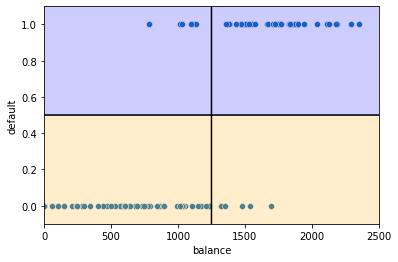

In [27]:
fig, ax = plt.subplots()

sns.scatterplot(y = (example["default"]=="Yes").astype(int), x =example["balance"], ax=ax)
plt.axline((0, 0.5), slope=0, c="black")
plt.axline((1250, 0), slope=90, c="black")
plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], -0.1, 0.5, color='orange', alpha=0.2)
plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], 0.5, 1.1, color='blue', alpha=0.2)
plt.xlim(0,2500)
plt.ylim(-0.1,1.1)

plt.show()

Is it a perfect model? Clearly not, we can see people who have larger ballances who don't default, but the model will predict that they did (False Positive). Similarly people with smaller ballances, our model will predict they didn't default when they do (False Negative).

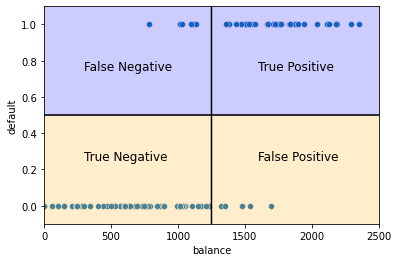

In [28]:
sns.scatterplot(y = (example["default"]=="Yes").astype(int), x =example["balance"])
plt.axline((0, 0.5), slope=0, c="black")
plt.axline((1250, 0), slope=90, c="black")
plt.text(300, 0.25, "True Negative", fontsize=12)
plt.text(300, 0.75, "False Negative", fontsize=12)
plt.text(1600, 0.25, "False Positive", fontsize=12)
plt.text(1600, 0.75, "True Positive", fontsize=12);

plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], -0.1, 0.5, color='orange', alpha=0.2)
plt.fill_between([ax.get_xlim()[0],ax.get_xlim()[1]], 0.5, 1.1, color='blue', alpha=0.2)
plt.xlim(0,2500)
plt.ylim(-0.1,1.1);

To improve this model we would have to add more features, like with linear regression. Classification models have bias and variance issues as well which lead to error. They have a range of performance metrics which we will look into later. Similarly to the last workbook though, we can use techniques like train/test split and cross validation to help us assess our models. 

This is essentially how logistic regression works. Lets recap, for each data point it will calculate the probability of assigning the default (first) label.

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(example["balance"].to_numpy().reshape(-1, 1), example["default"])

pd.DataFrame(logreg.predict_proba(example["balance"].to_numpy().reshape(-1, 1)).round(2)[:10], columns = ["No", "Yes"])

No   Yes
0  0.19  0.81
1  0.09  0.91
2  0.33  0.67
3  0.98  0.02
4  0.93  0.07
5  0.05  0.95
6  1.00  0.00
7  0.68  0.32
8  0.15  0.85
9  0.14  0.86

If that probability is lower than a threshold (usually 0.5) then it will assign the other label.

In [30]:
logreg.predict(example["balance"].to_numpy().reshape(-1, 1))[:10]

array(['Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes'],
      dtype=object)

You can change this 0.5 threshold value if you like, although do this carefully. 

In practice, what is going on behind the scenes is slightly more complicated, but we won’t be covering this.

__Advantages of logistic regression:__
- Highly interpretable (if you remember how).
- Model training and prediction are fast.
- No tuning is required (excluding regularisation).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Outputs well-calibrated predicted probabilities.

__Disadvantages of logistic regression:__
- Presumes a linear relationship between the features.
- Performance is (generally) not competitive with the best supervised learning methods.
- Can't automatically learn feature interactions.

---

### 🚩 Exercise 5

Examine and discuss the "accuracy" (default scoring method) of the following models (on default parameters) on the data:
- `DummyClassifier`: A model that only predicts the class that is the most common.
- `LogisticRegression`: See above.

What do you notice?

__Note__
- Using the `.score()` method on classification models defaults to "Accuracy".
- Like $R^2$ in regression, we want accuracy to be high (close to 1).

In [31]:
%run scripts/show_solutions.py 07_ex5

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Lets now look at other ways of examining our `LogisticRegression` model's performance other than just "accuracy" (which we will look at what that actually means).

## 6.2. Performance Metrics

A binary classifier can make two types of errors$^5$:
- Incorrectly assign an individual __who defaults__ to the __no default__ category (false negative).
- Incorrectly assign an individual who __does not default__ to the __default__ category (false positive).

Lets use a "confusion matrix" to break our models performance down into these these groups (and where it got it right).

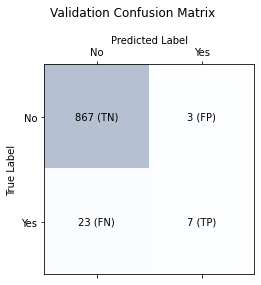

In [32]:
from sklearn.metrics import confusion_matrix
from helper_functions import pretty_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=43))])

log_pipe.fit(X_train, y_train)

# use the first classifier to predict the validation set    
predictions = log_pipe.predict(X_val)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_,
                        "Validation Confusion Matrix",
                        labeling=True)

While the overall error rate is low, the error rate among individuals who defaulted is very high. From the perspective of a credit card company that is trying to identify high-risk individuals, this error rate among individuals who default may well be unacceptable<sup>5</sup>.

---

### 🚩 Exercise 6

Using the information above, what would a confusion matrix look like for our dummy model on the validation data? 
- Check and see if this matches up with your expectation.

In [33]:
%run scripts/show_solutions.py 07_ex5

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
Thinking back to our model, why was our accuracy so high? Lets look how it was calculated...

**Error and Accuracy**$^1$

Gives general performance information regarding the number of all correct or false predictions comparative to the total number of predictions for both the positive and negative labels.

$$
\begin{align}
ERR &= \frac{FP+FN}{FP+FN+TP+TN} \\ \\
ACC &= 1-ERR
\end{align}
$$

__Notes__

- Using `sklearn.metrics` this can be gained using `accuracy_score(y_true=y_val, y_pred=predictions)`

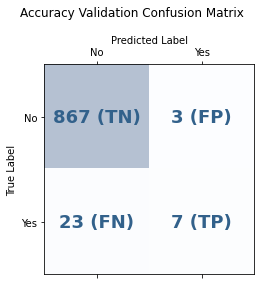

Error (ERR): 0.029
Accuracy (ACC): 0.971


In [34]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Accuracy Validation Confusion Matrix",
                        labeling=True, highlight_indexes=[FP_i,FN_i,TP_i,TN_i])

print(color.BOLD+'Error (ERR): '+color.END +'%.3f' % ERR)
print(color.BOLD+'Accuracy (ACC): '+color.END +'%.3f' % ACC)

So as we can see accuracy only tells part of the story. Lets look at some more.

**Precision (PRE)**$^1$

- Precision gives information on how precise your model is by looking at how many positive predicted labels are actually positive. 
- Precision is a good measure to determine, when the costs of a False Positive is high.

$$
PRE = \frac{TP}{TP+FP}
$$

__Notes__

- Using `sklearn.metrics` this can be gained using `precision_score(y_true=y_val, y_pred=predictions)`

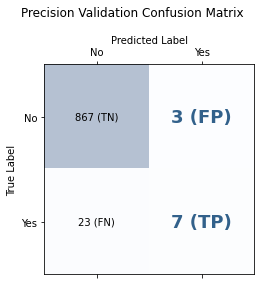

Precision (PRE): 0.700


In [35]:
PRE = TP/(TP+FP)

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Precision Validation Confusion Matrix",
                        labeling=True, highlight_indexes=[FP_i,TP_i])

print(color.BOLD+'Precision (PRE): '+color.END +'%.3f' % PRE)

As this model only predicted "yes" when it was "no" 3/10 times, our precision seems pretty good... but what about all of those false negatives...

**Recall (or True Positive Rate)**$^1$

- Calculates how many of the actual positives our model correctly or incorrectly labelled. 

- This is useful when the fraction of correctly or misclassified samples in the positive class are of interest.

$$
REC = \frac{TP}{FN+TP}
$$

__Notes__

- Using `sklearn.metrics` this can be gained using `recall_score(y_true=y_val, y_pred=predictions)`

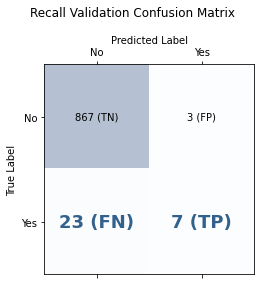

Recall (REC): 0.233


In [36]:
REC = TP/(FN+TP)

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Recall Validation Confusion Matrix",
                        labeling=True, highlight_indexes=[FN_i,TP_i])

print(color.BOLD+'Recall (REC): '+color.END +'%.3f' % REC)

This one doesn't look so good and is where our model is having the most issues. It is predicting a lot of defaults and not defaulting!

**F1-score**$^1$

- F1-score is a combination of Recall and Precision. 
- It is typically used when there is an __uneven class distribution__ due to a large number of True Negatives that you are not as focused on. 

$$
F1 = 2\left(\frac{PRE \times REC}{PRE + REC}\right)
$$

__Notes__

- Using `sklearn.metrics` this can be gained using `f1_score(y_true=y_val, y_pred=predictions)`

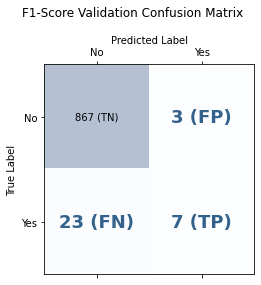

F1-Score (F1): 0.350


In [37]:
F1 = 2*((PRE*REC)/(PRE+REC))

pretty_confusion_matrix(confmat, LE.classes_, 
                        "F1-Score Validation Confusion Matrix",
                        labeling=True, highlight_indexes=[FN_i,TP_i, FP_i])

print(color.BOLD+'F1-Score (F1): '+color.END +'%.3f' % F1)

---

We can use a classification report, which gives more information such as the macro avg and weighted avg.

 **Macro Average**
 - Treats all classes equally as each metric is calculated independently and the average is taken.

**Weighted Average** 
- Each contribution to the average is weighted by the relative number of examples in a class available.

__Notes__

- The support is the number of occurrences of each class in y_true.
- Notice how the previous metrics were based on the `"yes"` class. This is because in binary classification problems, the default positive label is the target (class 1). You can change this if you are more interested in the other classes performance or the average metrics.

In [38]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, 
                                   predictions, 
                                   labels=None, 
                                   target_names=LE.classes_, 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True)).round(2)

No    Yes  accuracy  macro avg  weighted avg
precision    0.97   0.70      0.97       0.84          0.97
recall       1.00   0.23      0.97       0.61          0.97
f1-score     0.99   0.35      0.97       0.67          0.96
support    870.00  30.00      0.97     900.00        900.00

__Notes__

- For further reading on different performance metrics see David M. W. Powers' technical report [Evaluation: From Precision,  Recall and F-Factor to ROC, Informedness, Markedness & Correlation](https://arxiv.org/ftp/arxiv/papers/2010/2010.16071.pdf)

---
## 6.3. K-Nearest Neighbours (KNN)

KNN is a **non-parametric model**, meaning the model is not represented as an equation with parameters (e.g. the $\beta$ values in linear regression). For parametric models, training data is used to learn a mathematical equation that models the data and once a model is learned, we no longer need the training data. However in the nearest neighbors algorithm, the data is the model as when we encounter a new data sample, we compare it to the training dataset. 

> You may have heard of the clustering algorithm **k-Means Clustering**. These techniques have nothing in common, aside from both having a parameter $k$!

In [39]:
from sklearn.neighbors import KNeighborsClassifier

K-nearest neighbors classification is (as its name implies) a classification model that uses the $K$ most similar observations in order to make a prediction. K-nearest samples in the training set are compared to the newly encountered sample, and then we use the class labels of the $K$ samples in the training set to assign a label to the new sample.

KNN is a supervised learning method; therefore, the training data must have known target values.

The process of of prediction using KNN is fairly straightforward:

1. Pick a value for K.
2. Search for the K observations in the data that are "nearest" to the measurements of the unknown value you are trying to predict.
    - Euclidian distance is often used as the distance metric, but other metrics are allowed.
3. Use the most popular response value from the K "nearest neighbors" as the predicted response value for the unknown value.

__Notes__

- _"The concept of training doesn't really exist here. Unlike other algorithms, where the training time is dependent on the amount of training data, the computational cost is mostly spent in the nearest neighbors algorithm at prediction time."_<sup>1</sup>

- _"Most of the recent research done on the nearest neighbors algorithm is focused on finding the optimum ways to quickly search through the training data during prediction time."_<sup>1</sup>

---
1. Amr, T. (2020). Hands-On Machine Learning with scikit-learn and Scientific Python Toolkits.

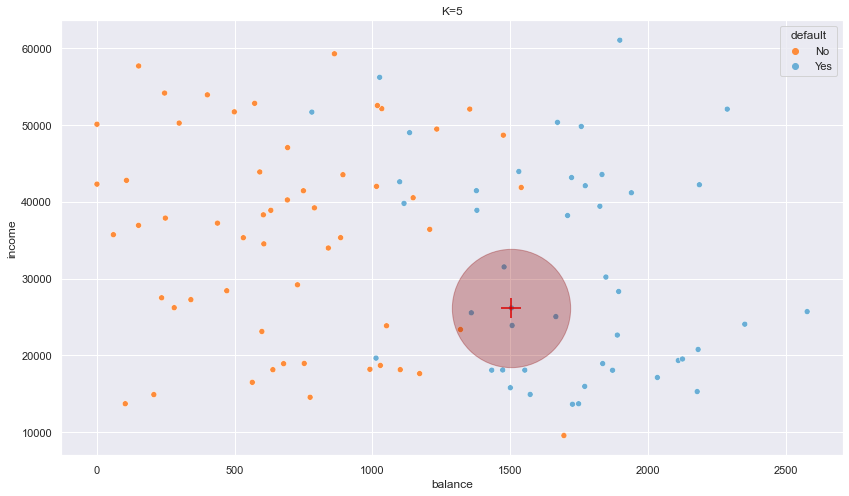

In [40]:
sns.set(rc={'figure.figsize': (14, 8)}) 

sns.scatterplot(data = example[example['default']=="No"], x = "balance", y="income", hue="default", palette='Oranges')
sns.scatterplot(data = example[example['default']=="Yes"], x = "balance", y="income",hue="default", palette='Blues')

plt.scatter(data = example.iloc[0], x = "balance",
            y="income", marker="+", c="red", s=400)

plt.scatter(data = example.iloc[0], x = "balance",
            y="income", color = "darkred", alpha = 0.3, s=14000)

plt.title("K=5");

So in the example above we have a new bit of data we want to predict (red cross). We set `k=5` so it looks at the 5 closest points (those inside the red circle). It will add up how many class 0 ("No") and how many class 1 ("Yes") there are and assign the one with the most (so in this case "Yes").

---

### 🚩 Exercise 7

Using the KNN approach on the scatterplot below, visually see what class you would assign the cross to if you were using `k=3`.

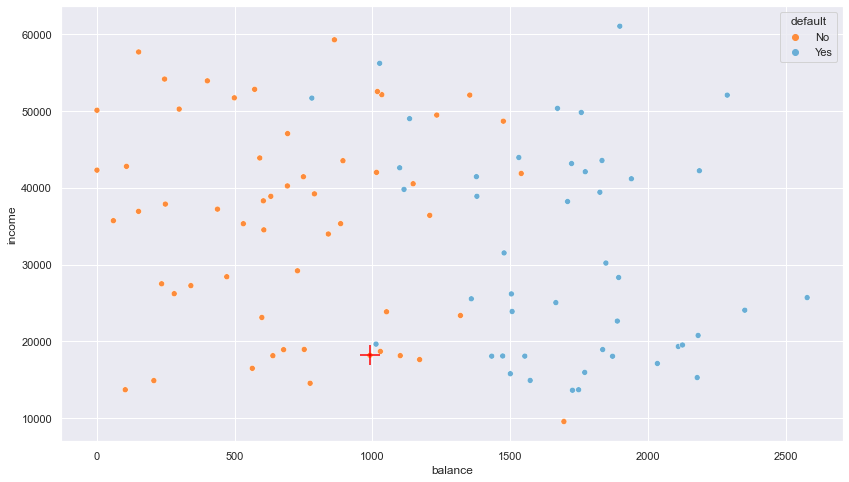

In [41]:
sns.set(rc={'figure.figsize': (14, 8)}) 

sns.scatterplot(data = example[example['default']=="No"], x = "balance", y="income", hue="default", palette='Oranges')
sns.scatterplot(data = example[example['default']=="Yes"], x = "balance", y="income",hue="default", palette='Blues')

plt.scatter(data = example.iloc[59], x = "balance",
            y="income", marker="+", c="red", s=400);

In [42]:
%run scripts/show_solutions.py 07_ex7

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
It is highly reccomended that for KNN you scale the data before fitting the model. This is because the way "distance" is measured is affected by the scale of the values. For example, `balance` ranges between 0 - 2500, but income ranges from 10000 - 60000. 

Lets look at what happens to how KNN makes a decision if we don't scale our features first. Below is a "decision boundary" meaning any new points that land in the orange region will be assigned to "No" and any in blue to "Yes".

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


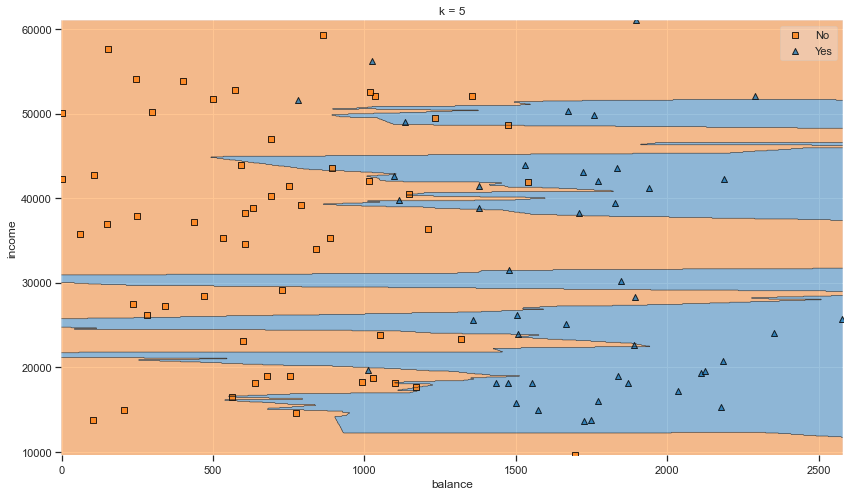

In [43]:
from mlxtend.plotting import plot_decision_regions

knn_pipe = Pipeline([
    #("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())])
knn_pipe.fit(example[['balance', 'income']].to_numpy(), 
             LE.transform(example[['default']].to_numpy()))

# Plotting decision regions
ax = plot_decision_regions(example[['balance', 'income']].to_numpy(), 
                      LE.transform(example[['default']].to_numpy()), 
                      clf=knn_pipe, legend=2, colors='#ff7f0e,#1f77b4')


# add legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ["No", "Yes"],
           framealpha=0.3, scatterpoints=1)

# Adding axes annotations
plt.xlabel("balance")
plt.ylabel("income")
plt.title("k = 5")

plt.show()

This looks very spikey, and the boundaries don't really look to be where to might expect. This is because the decision on what is closest is being made primarily using income (the y-axis) so the model is only looking at points above or below and not along the x-axis as well. If we scale our features so they are on a similar scale...

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


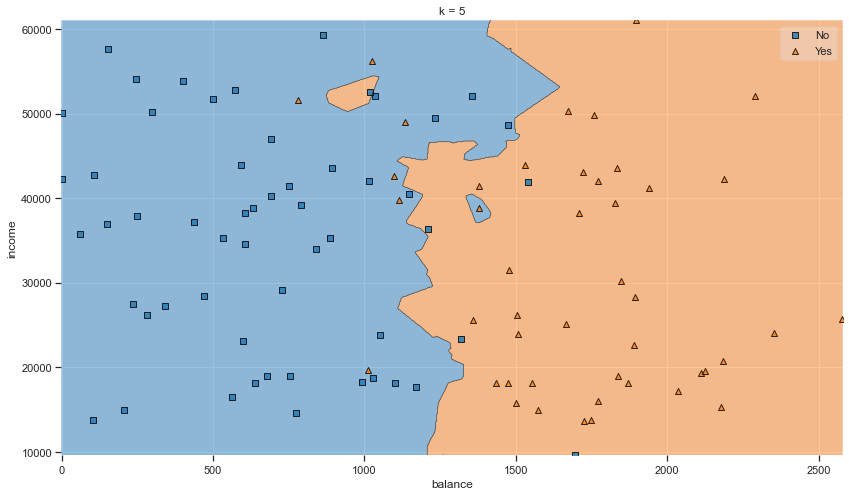

In [44]:
from mlxtend.plotting import plot_decision_regions

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())])
knn_pipe.fit(example[['balance', 'income']].to_numpy(), 
             LE.transform(example[['default']].to_numpy()))

# Plotting decision regions
ax = plot_decision_regions(example[['balance', 'income']].to_numpy(), 
                      LE.transform(example[['default']].to_numpy()), 
                      clf=knn_pipe, legend=2)

# add legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ["No", "Yes"],
           framealpha=0.3, scatterpoints=1)

# Adding axes annotations
plt.xlabel("balance")
plt.ylabel("income")
plt.title("k = 5")

plt.show()

...It looks a little more like you would expect (uses what is closest using _both_ the x and y axis).

---

### 🚩 Exercise 8

Fit a KNN model and assess its performance comparative to the logisitic regression model.

In [45]:
%run scripts/show_solutions.py 07_ex8

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
# 7.  Model Refinement <a id='refine'></a>

So far our models are pretty poor. In fact, with only these two bits of information we will find that it is quite difficult to find a model that has high performance across all our metrics (accuracy, precision, recall, ect.) anyway. But what we will find is that in this case we are going to need to build a model that priorises one metric over the others.

Lets start by looking at the hyperparameters for logistic regression to see how changing them changes our "decision boundary".

## 7.1. Model Parameters

For our logistic regression model, lets start by looking at the effects of changing the regularization strength ($C$). Regularization is where we apply a penalty to large parameter values in order to reduce overfitting. Essentially, when the model is relying too much on particular datapoints, we penalise it. This reduces the chance our model fits to the noise of our data rather than the underlying structure which will generalise well to new data.

Just to confuse things a little, $C$ in Scikit-Learn is the __inverse of regularization strength__, so smaller values specify stronger regularization (therefore penalising the model more for relying on the training data too much).

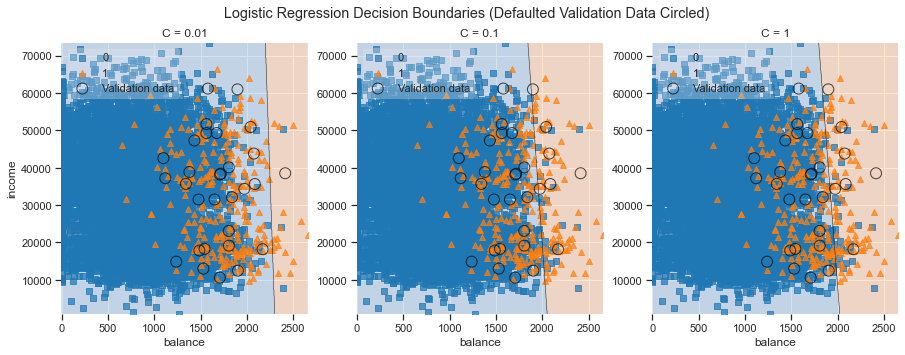

In [46]:
from mlxtend.plotting import plot_decision_regions
import warnings

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, axes = plt.subplots(figsize=(15,5), ncols=3)
    axes = axes.flatten()
    
    for i, c in enumerate([0.01, 0.1, 1]):
        
        log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])

        log_pipe.fit(X_train, y_train)
    
        plot_decision_regions(X_train, y_train, clf=log_pipe, 
                              legend=2, X_highlight=X_val[y_val==1],
                              contourf_kwargs=contourf_kwargs,
                              scatter_kwargs=scatter_kwargs,
                              scatter_highlight_kwargs=scatter_highlight_kwargs,
                              ax=axes[i])
        
        axes[i].set_title("C = {}".format(c))
        axes[i].set_xlabel("balance")
        if i == 0:
            axes[i].set_ylabel("income")
        
    plt.suptitle("Logistic Regression Decision Boundaries (Defaulted Validation Data Circled)")

---

### 🚩 Exercise 9

Using the figure above, discuss the effect of $C$ on the decision boundary for the logistic regression model.

In [47]:
%run scripts/show_solutions.py 07_ex9

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
You can also look at decision boundaries for KNN's. They are non-linear and can be prone to overfitting a bit as seen below.

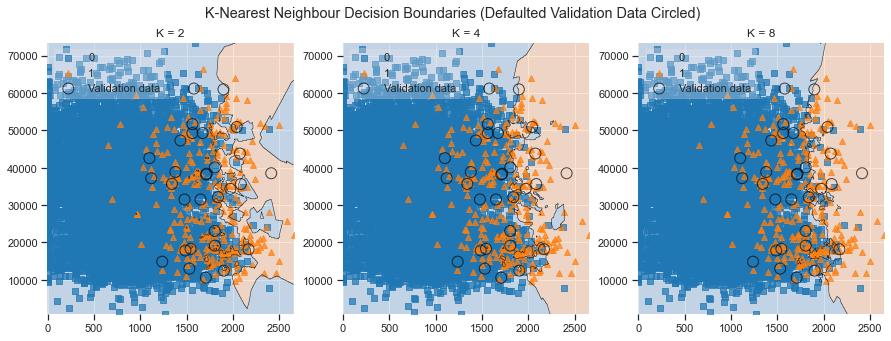

In [48]:
from mlxtend.plotting import plot_decision_regions

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, axes = plt.subplots(figsize=(15,5), ncols=3)
    axes = axes.flatten()
    
    for i, k in enumerate([2, 4, 8]):
        
        knn_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", KNeighborsClassifier(n_neighbors = k))])
        knn_pipe.fit(X_train, y_train)
    
        plot_decision_regions(X_train, y_train, clf=knn_pipe, 
                              legend=2, X_highlight=X_val[y_val==1],
                              contourf_kwargs=contourf_kwargs,
                              scatter_kwargs=scatter_kwargs,
                              scatter_highlight_kwargs=scatter_highlight_kwargs,
                              ax=axes[i]
                             )
        
        axes[i].set_title("K = {}".format(k))
        
    plt.suptitle("K-Nearest Neighbour Decision Boundaries (Defaulted Validation Data Circled)")

---

### 🚩 Exercise 10

Using the figure above, discuss the effect of $K$ on the decision boundary for the KNN model.

In [49]:
%run scripts/show_solutions.py 07_ex10

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

## 7.2. Hyperparameter Tuning

$c$ in logistic regression and $k$ in k-nearest neighbours are examples of _"hyperparameters"_. The sensitivity to hyperparameter settings change depending on the classifier; for example logistic regression is relatively insensitive to hyperparameter settings. However it is still necessary to find the right range of hyperparameters, otherwise differences between models may just be down to the default tuning parameters rather than the behavior of the model or features.

Before we start manually searching over lots of hyperparameters to find our best (or "optimal") model, we could look at automating this process using a search method. Two methods are the most common, "Gridsearch" and "Randomsearch".

### Grid Search

A grid search is an exhaustive search paradigm where we specify a list inside a dictionary with various values for different hyperparameters. The computer will use this list to evaluate the model performance for each combination of values to obtain the set that scorers best on the given performance metric<sup>1</sup>.

Lets start by setting a range of values for two of logistic regressions parameters (`C` and `class_weight`).

__Notes__
- The "`model__`" part in front of `C` and `class_weight` is there because we will be using a `pipeline`. You need to first specify the name of the pipeline step (`"model"`), then `"__"`, and then the hyperparameter "`C`".

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [50]:
# make a parameter grid with the range of hyperparameteer values of interest
PARAM_GRID = {'model__C': [0.5, 1.0, 2.0, 4.0, 8.0], 
              'model__class_weight': [None, 'balanced']}

To search all the possible combinations of the parameters above, it will use each and perform a cross-validation.

In [51]:
from sklearn.model_selection import KFold
KF = KFold(n_splits=5)

We need to pick a metric (or metrics) to use to examine our model perfomance. Lets use F1 score for now...

In [52]:
from sklearn.metrics import make_scorer, f1_score

SCORER = make_scorer(score_func=f1_score)

Now lets look at how to apply a gridsearch. I've put it into a function to keep things tidy so take a moment to look over its parts.

__Notes__

- If the grid param scores were the maximum values evaluated you should try increasing the values to see if the score will improve
- Once we've found the optimal hyperparamters we can then actually use these optimal hyper-parameters to re-train our final model on the full training set (including the validation data) to make the model slightly more accurate$^1$. If we set `refit = True` (the default anyway), then this will do this for us for the best estimator.
- We'll be using just the training set and later looking how it works on the validation set - granted we could look at combining these again as the cross-validation is creating subsets so potentially makes the validation set redundent... but having a separate validation set helps for later questions...

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [53]:
%%time
from sklearn.model_selection  import GridSearchCV

def Grid_Search(X_train, y_train, estimator, cv, 
                param_grid, scorer):

  # create gridsearch object
  gs = GridSearchCV(estimator=estimator,       # model/pipeline to search over
                    param_grid=param_grid,     # a dictionary of parameters to search
                    scoring=scorer,            # the metric to score them on
                    cv=cv,                     # cross-validation method
                    return_train_score=True,   # whether to return the training data
                    refit = True,              # whether to train a model with the "best parameters"
                    n_jobs=1)                  # -1 if you want to run in parallel

  # fit the gridsearch object
  gs = gs.fit(X_train, y_train)

  # get the results of the gridsearch
  results = pd.DataFrame(gs.cv_results_)

  # select the best estimator
  clf_pipe = gs.best_estimator_

  display(results[['mean_fit_time','mean_score_time',
                   'params','mean_test_score',
                   'std_test_score']].sort_values(by='mean_test_score',
                                                  ascending =False).head())

  return clf_pipe, results

best_pipe, log_grid_results = Grid_Search(X_train, y_train, log_pipe, 
                                          KF, PARAM_GRID, SCORER)

mean_fit_time  mean_score_time  \
4       0.007885         0.000019   
6       0.007029         0.001006   
8       0.006118         0.000936   
2       0.005964         0.000000   
0       0.008822         0.001402   

                                           params  mean_test_score  \
4  {'model__C': 2.0, 'model__class_weight': None}         0.456649   
6  {'model__C': 4.0, 'model__class_weight': None}         0.456649   
8  {'model__C': 8.0, 'model__class_weight': None}         0.456649   
2  {'model__C': 1.0, 'model__class_weight': None}         0.453947   
0  {'model__C': 0.5, 'model__class_weight': None}         0.445861   

   std_test_score  
4        0.044901  
6        0.044901  
8        0.044901  
2        0.042967  
0        0.044224

Wall time: 537 ms


We can also use stratified k-fold cross-validation, as it can yield better bias and variance estimates in cases of unequal class proportions than RepeatedKFold. This is because "stratified" refers to sampling where the classes are separated into "strata" and a probability sample is drawn from each group.

Its worth noting that some of the folds may not have the same distribution of the classes. This means we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual). Therefore when doing our gridsearch/randomsearch, we should use a StratifiedKFold to ensure the distribution of classes in our folds reflects the distribution in the larger data.

In [54]:
from sklearn.model_selection import StratifiedKFold

KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    print(color.BOLD+color.UNDERLINE+fold_names[i]+color.END)
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts(), columns=["Fold "+str(j)])
        if j == 0:
            fold_nos = fold_no
        else:
            fold_nos = pd.concat([fold_nos,fold_no], axis=1)
        
    display(fold_nos)

KFold


Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1570    1557    1571    1571    1561
1      50      63      49      49      59

StratifiedKFold


Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1566    1566    1566    1566    1566
1      54      54      54      54      54

---

### 🚩 Exercise 11

Change the above gridsearch to use a `StratifiedKFold` instead of a normal k-fold.
- Does this change what hyperparameters are seen as the "best"?

In [55]:
%run scripts/show_solutions.py 07_ex11

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 12

Conduct a gridsearch to find an optimal value for the `k` hyperparameter for a KNN model. Can you find a model that has improved performance vs. default settings?

__Notes__
- The `scoring` parameter can take multiple values so you can assess different performance metrics (e.g. `scoring = ["accuracy", "f1","recall","precision"]`). If you do this and want the search cv to output a fitted model, you need to specify what metric to use as the one to find the "best parameters" (e.g. `refit="accuracy"`).

In [56]:
%run scripts/show_solutions.py 07_ex12

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### Random Search

Although a powerful method, gridsearch is computationally expensive as it has to evaluate all the possible parameter combinations. If we were working with a larger dataset or wanting to search lots of hyperparameter options, it is much better to randomly sample different random parameter combinations within a given range using RandomizedSearchCV<sup>1</sup>.

You can provide distributions for sampling parameters as demonstrated for $c$ below. The distributions just make it more likely a value will be picked within a certain range. For example an exponential continuous random variable could be set so its more likely to get a lower number. Lets plot 1000 random samples and see where they lie.

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

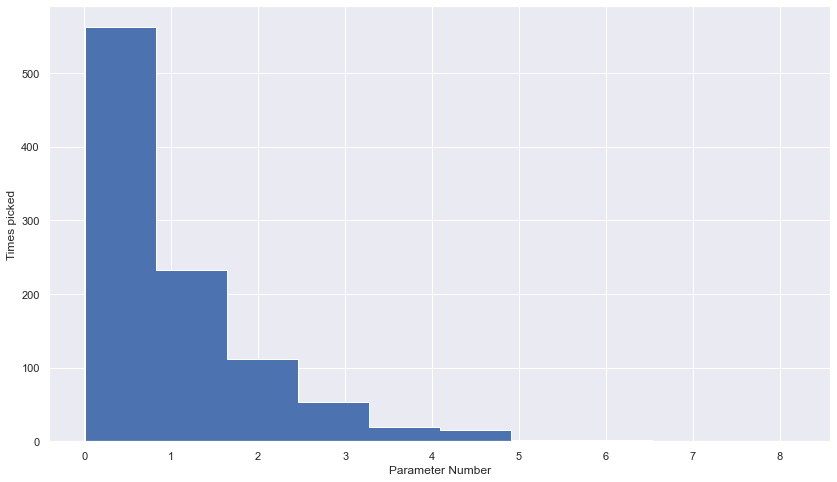

In [57]:
from scipy.stats import expon

plt.hist(expon(scale=1).rvs(size=1000), histtype='stepfilled')
plt.xlabel('Parameter Number')
plt.ylabel('Times picked')
plt.show()

...or you could use a gamma continuous random variable to provide a more 'normal' distribution.

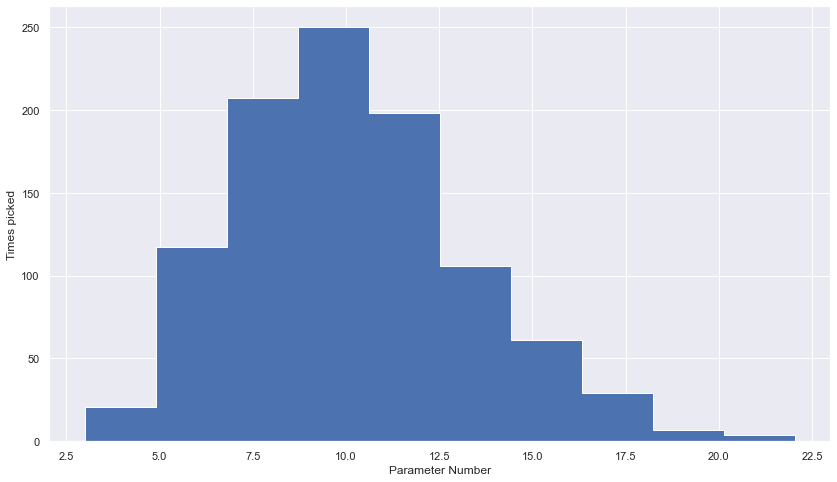

In [58]:
from scipy.stats import gamma

plt.hist(gamma(a=10, scale=1).rvs(size=1000), histtype='stepfilled')
plt.xlabel('Parameter Number')
plt.ylabel('Times picked')
plt.show()

So instead of a set parameter dictionary lets provide our C with a random number between 0.01 and 1.

In [59]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':uniform(0.01, 1),
                  'model__class_weight': [None, 'balanced']
                 }

log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions=log_param_dist,
                            n_iter=30, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv=StratifiedKFold(n_splits=5),
                            refit="accuracy", 
                            random_state=42,
                            return_train_score=True)

log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(C=1,
                                                                 random_state=42))]),
                   n_iter=30,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027AA011F730>,
                                        'model__class_weight': [None,
                                                                'balanced']},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [60]:
log_rs_df = pd.DataFrame(log_rs.cv_results_)
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                              "param_model__class_weight",
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

param_model__C param_model__class_weight  mean_train_accuracy  \
15       0.983756                      None             0.973951   
11       0.621653                      None             0.973951   
2        0.608658                      None             0.973951   
20       0.617545                      None             0.973951   
26       0.450152                      None             0.973796   

    std_train_accuracy  mean_test_accuracy  std_test_accuracy  
15            0.000299            0.973951           0.001197  
11            0.000344            0.973827           0.001145  
2             0.000344            0.973827           0.001145  
20            0.000344            0.973827           0.001145  
26            0.000299            0.973704           0.001271

---

### 🚩 Exercise 13

Conduct a random search to find an optimal value for the `k` hyperparameter for a KNN model. Can you find a model that has improved performance vs. default settings?

__Hint__
- `n_neighbors` takes an int and not a float so to select a random integer you could use `randint` from `scipy.stats`

In [61]:
%run scripts/show_solutions.py 07_ex13

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
# 8. Summary <a id='sum'></a>

For the sake of this workshop you are now done - well done! 

Hopefully you feel we have addressed the aim of getting an overview of how to use some classical classification models.

---

# 9. Extra Exercises <a id='extra'></a>

Here are some extra exercises around improving your models when you outcome classes are highly imballanced.

## 9.1. Improving Models with Imballances

There are a number of methods available to address imbalances in a dataset when we refine our models, such as:
1. Weighting the classes in the model during training, 
2. Changing the training metric, 
3. Resampling the data.

### Weights

During model fitting we can assign a larger penalty to wrong predictions on the minority class.

The heuristic used for `class_weight="balanced"` in Scikit-Learn (0.23.1) is:

$$
\frac{n}{Nc \times \sum\limits^n_{i=1}I(y_i \in S)},
$$

where $n$ are the number of samples, $Nc$ the number of classes, $I$ is an indicator function, and $S$ contains the class elements.

We've been using this so far, and it doesn't seem to be doing much for us, so lets look at some other options.

### Changing Training/Validation Metric

__Optimising for Accuracy__ 

During hyperparamter cross-validation the default is to choose the model with the best __overall accuracy__. 

This gives us a model with the smallest possible total number of misclassified observations, irrespective of which class the errors come from$^5$. 

ML algorithms typically optimize a reward or cost function computed as a sum over the training examples, the decision rule is likely going to be biased toward the majority class$^9$.

__Notes__

- _"In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to minimize the cost or  maximize the reward during training."_<sup>9</sup>. 

In [62]:
display(pd.DataFrame(classification_report(y_val, 
                                   log_rs.predict(X_val), 
                                   labels=None, 
                                   target_names=list(LE.classes_), 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True)).round(2))

No    Yes  accuracy  macro avg  weighted avg
precision    0.97   0.70      0.97       0.84          0.97
recall       1.00   0.23      0.97       0.61          0.97
f1-score     0.99   0.35      0.97       0.67          0.96
support    870.00  30.00      0.97     900.00        900.00

Changing the metric for what is defined as the _"best model"_ can help us prioritise models that make particular errors.

For example, a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who will not default, though still to be avoided, is less problematic. 

In this case, __recall__ would therefore be a useful metric to use.

Rather than run another cross-validation again, provided that in `scoring` you used a list that contained "recall", we can just use our results data to pick the model with the best "recall" instead of accuracy.

In [63]:
log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_recall", 
                                                                  "std_test_recall"]].head()

param_model__class_weight param_model__C  mean_test_recall  std_test_recall
9                   balanced       0.010779          0.903704         0.018144
18                  balanced       0.524234          0.896296         0.018885
21                  balanced       0.460499          0.896296         0.018885
1                   balanced       0.193435          0.896296         0.018885
14                  balanced       0.149494          0.896296         0.018885

Now we see that `balanced` models are indeed better if we want a good average recall.

Lets use the output scores to our advantage and build a function that sets the parameters to the best for that particular metric and then fits our model using the full training data.

In [64]:
from sklearn.base import clone

# uses the gridsearch or randomsearch object to refit a model
# on all the data.
def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_"+metric, ascending=False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model

rec_model = manual_refit(log_pipe, X_train, y_train, log_rs, "recall")

---

### 🚩 Exercise 14 (Extra)

Compare the model above (`rec_model`) to the one with the best accuracy on the validation set. How do they compare?

In [65]:
%run scripts/show_solutions.py 07_ex14

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

### Resampling

We can change the distribution of the classes in our training data so the model is less affected by the fact there are more of one class (this tends to work well when the class imballance is particularly large like this case!).

#### Under-Sampling

A fast way to balance the data is just to randomly select a subset of the data for each class so they have the number of datapoints found in the smallest class.

__Notes__

- `RandomUnderSampler` is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.
- There is a `resample` method in scikit-learn but Imblearn is a bit smoother to work with.

In [66]:
from imblearn.under_sampling import RandomUnderSampler

X_train_down, y_train_down = RandomUnderSampler().fit_resample(X_train,
                                                  y_train)

pd.Series(y_train_down).value_counts()

0    270
1    270
dtype: int64

---

### 🚩 Exercise 15 (Extra)

Plot the data using a scatterplot before and after undersampling the data.

In [67]:
%run scripts/show_solutions.py 07_ex15

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
If you want to use a sampler in a model pipeline then you can use the pipeline from `imblearn`. Using a sampler in a pipeline ensure you wont be training __and__ validating your data on a smaller/larger sample than normal and get unrepresentative results! 

__Note__
- This is an easy mistake to make... I did it when setting this up :')

In [68]:
from imblearn.pipeline import Pipeline as ImPipeline

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=123)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':uniform(0.01, 1)}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions=log_param_dist,
                            n_iter=60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv=StratifiedKFold(n_splits=5),
                            refit="recall", 
                            random_state=42,
                            return_train_score=True)

us_log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027AA013D7F0>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [69]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

param_model__C  mean_test_recall  std_test_recall
10       0.030584          0.903704         0.018144
37       0.107672          0.900000         0.014815
29        0.05645          0.900000         0.014815
6        0.068084          0.900000         0.014815
42       0.044389          0.900000         0.014815

#### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples. 

__Notes__
- make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model<sup>7</sup>... In-other-words, make sure it is in a pipeline!

---

### 🚩 Exercise 16 (Extra)

Visualise the effects of oversampling and then conduct a cross-validation search for optimal parameters.

In [70]:
%run scripts/show_solutions.py 07_ex16

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 17 (Extra)

Have a look at the other resampling methods available in `imblearn`. What are they useful for and how do they affect the data?

In [71]:
%run scripts/show_solutions.py 07_ex17

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 18 (Extra)

Conduct a hyperparameter search to see if a logistic regression or knn model can provide better recall using different methods to account for the imballance (Weights, Resampling).

- Then examine their performance on the test set.

In [72]:
%run scripts/show_solutions.py 07_ex18

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

# References

__TODO__
- go through these and find the ones I ended up using

1. https://scikit-learn.org/stable/datasets/toy_dataset.html
2. Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.
5. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
6. http://contrib.scikit-learn.org/imbalanced-learn/stable/introduction.html
7. https://beckernick.github.io/oversampling-modeling/
8. Mani, I., & Zhang, I. (2003, August). kNN approach to unbalanced data distributions: a case study involving information extraction. In Proceedings of workshop on learning from imbalanced datasets (Vol. 126).
9. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
10. Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning. The Journal of Machine Learning Research, 18(1), 559-563.
11. Wilson, D. L. (1972). Asymptotic properties of nearest neighbor rules using edited data. IEEE Transactions on Systems, Man, and Cybernetics, (3), 408-421.
12. Tomek, I. (1976). Two modifications of CNN. IEEE Trans. Systems, Man and Cybernetics, 6, 769-772.
13. Batista, G. E., Prati, R. C., & Monard, M. C. (2004). A study of the behavior of several methods for balancing machine learning training data. ACM SIGKDD explorations newsletter, 6(1), 20-29.
14. https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
15. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
16. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc.".
17. https://bradleyboehmke.github.io/HOML/svm.html